In [31]:
#LQG waveform generator
import numpy as np
from scipy.integrate import quad,solve_ivp
from scipy.special import jv
#使用几何单位制
GM_SUN_S=4.925490947e-6
PC_M=3.08567758149e16
GPC_M=PC_M*1e9
class LQGWaveformGenerator:
    def __init__(self,M_sol,m_sol,r0,p0,e0,D_L,T_obs_yr=1):
        self.M_sol=M_sol
        self.m_sol=m_sol
        self.r0=r0
        self.p0=p0
        self.e0=e0
        self.D_L=D_L

        #单位转换
        self.M_sec=M_sol*GM_SUN_S
        self.m_sec=m_sol*GM_SUN_S

        self.mu_sec=self.m_sec
        self.mu=self.mu_sec/self.M_sec
        self.eta=self.mu
        self.D_L=(D_L*GPC_M)/(self.M_sec*299792458)
        self.T_obs=T_obs_yr*31536000/self.M_sec

    def get_orbital_frequencies(self,p,e):
        pre_factor=(1-e**2)**(3/2)/p**(3/2)
        term_phi_lqg=e**2*(1-e**2)**(3/2)*(6+self.r0)/(2*p**(5/2))
        omega_phi=pre_factor+term_phi_lqg
        term_r_lgq=-(1-e**2)**(5/2)*(6+self.r0)/(2*p**(5/2))
        omega_r=pre_factor+term_r_lgq
        return omega_r,omega_phi
    
    def get_fluxes(self,p,e):
        f_E_GR=(1+(73/24)*e**2+(37/96)*e**4)
        f_L_GR=(1+(7/8)*e**2)

        common_factor_GR=-(32/5)*self.eta**2*(1-e**2)**(3/2)
        dEdt_GR=common_factor_GR/p**5*f_E_GR
        dLdt_GR=common_factor_GR/p**(7/2)*f_L_GR

        f_E_GR_sub=e**2*3*(176+450*e**2+53*e**4)
        dEdt_GR_sub=-(1/15)*self.eta**2*self.r0*(1-e**2)**(3/2)/p**6*f_E_GR_sub
        f_L_GR_sub=e**2*4*(38+27*e**2)
        dLdt_GR_sub=-(1/15)*self.eta**2*(1-e**2)**(3/2)/p**(9/2)*f_L_GR_sub
        f_E_LQG=e**2*(564+843*e**2+70*e**4)
        f_L_LQG=e**2*(104+41*e**2)

        dEdt_LQG=-(1/15)*self.eta**2*self.r0*(1-e**2)**(3/2)/p**6*f_E_LQG
        dLdt_LQG=-(1/5)*self.eta**2*self.r0*(1-e**2)**(3/2)/p**(9/2)*f_L_LQG

        dEdt=dEdt_GR+dEdt_LQG+dEdt_GR_sub
        dLdt=dLdt_GR+dLdt_LQG+dLdt_GR_sub
        return dEdt,dLdt
    
    def evolution_ode(self,t,y):
        p,e,_,_=y
        if e<0 or p<2*(1+e):
            return [0,0,0,0]
        dEdt,dLdt=self.get_fluxes(p,e)
        dEdt_norm=dEdt/self.eta
        dLdt_norm=dLdt/self.eta
        dpdt=-2*np.sqrt(p)*(p*dEdt_norm-np.sqrt(p/(1-e**2))*dLdt_norm)
        dedt=-(1-e**2)/e*(np.sqrt((1-e**2)/p)*dLdt_norm-(1-e**2)/np.sqrt(p)*dEdt_norm)
        omega_r,omega_phi=self.get_orbital_frequencies(p,e)
        dphi_r_dt=omega_r
        dphi_phi_dt=omega_phi
        return [dpdt,dedt,dphi_r_dt,dphi_phi_dt]
    
    def evolve_trajectory(self):
        y0=[self.p0,self.e0,0,0]
        t_span=[0,self.T_obs]
        def stop_condition(t,y):
            p,e,_,_=y
            return p-2*(1+e)
        
        stop_condition.terminal=True
        stop_condition.direction=-1
        sol=solve_ivp(
            self.evolution_ode,
            t_span,
            y0,
            method='RK45',
            dense_output=True,
            events=stop_condition,
            rtol=1e-9,atol=1e-10
        )
        self.evolution_results=sol
        return sol
    
    def generate_waveform(self,times,incl,phi0):
        sol=self.evolution_results.sol
        p_t,e_t,phi_r_t,phi_phi_t_rel=sol(times)
        _,omega_phi_vals=self.get_orbital_frequencies(p_t,e_t)
        phi_phi_t=phi_phi_t_rel+phi0
        amp_factor=2*self.mu/self.D_L
        h_plus=np.zeros_like(times)
        h_cross=np.zeros_like(times)
        n_max=30
        cos_i=np.cos(incl)
        sin_i=np.sin(incl)
        for n in range(1,n_max+1):
            arg=n*e_t
            J_n_minus_2=jv(n-2,arg)
            J_n_minus_1=jv(n-1,arg)
            J_n=jv(n,arg)
            J_n_plus_1=jv(n+1,arg)
            J_n_plus_2=jv(n+2,arg)
            g_n=n*phi_phi_t+phi_r_t

            term1=-(1+cos_i**2)*np.cos(g_n)*(J_n_minus_2-2*e_t*J_n_minus_1+2/n*J_n+2*e_t*J_n_plus_1-J_n_plus_2)
            term2=sin_i**2*np.cos(g_n)*(J_n_minus_2-2*J_n+J_n_plus_2)
            h_plus_n=term1+term2
            h_cross_n=-2*cos_i*np.sin(g_n)*(J_n_minus_2-2*e_t*J_n_minus_1+2/n*J_n-2*e_t*J_n_plus_1+J_n_plus_2)
            commom_amp=amp_factor*(n*omega_phi_vals)**(2/3)
            h_plus+=commom_amp*h_plus_n
            h_cross+=commom_amp*h_cross_n
            
        return h_plus,h_cross
    

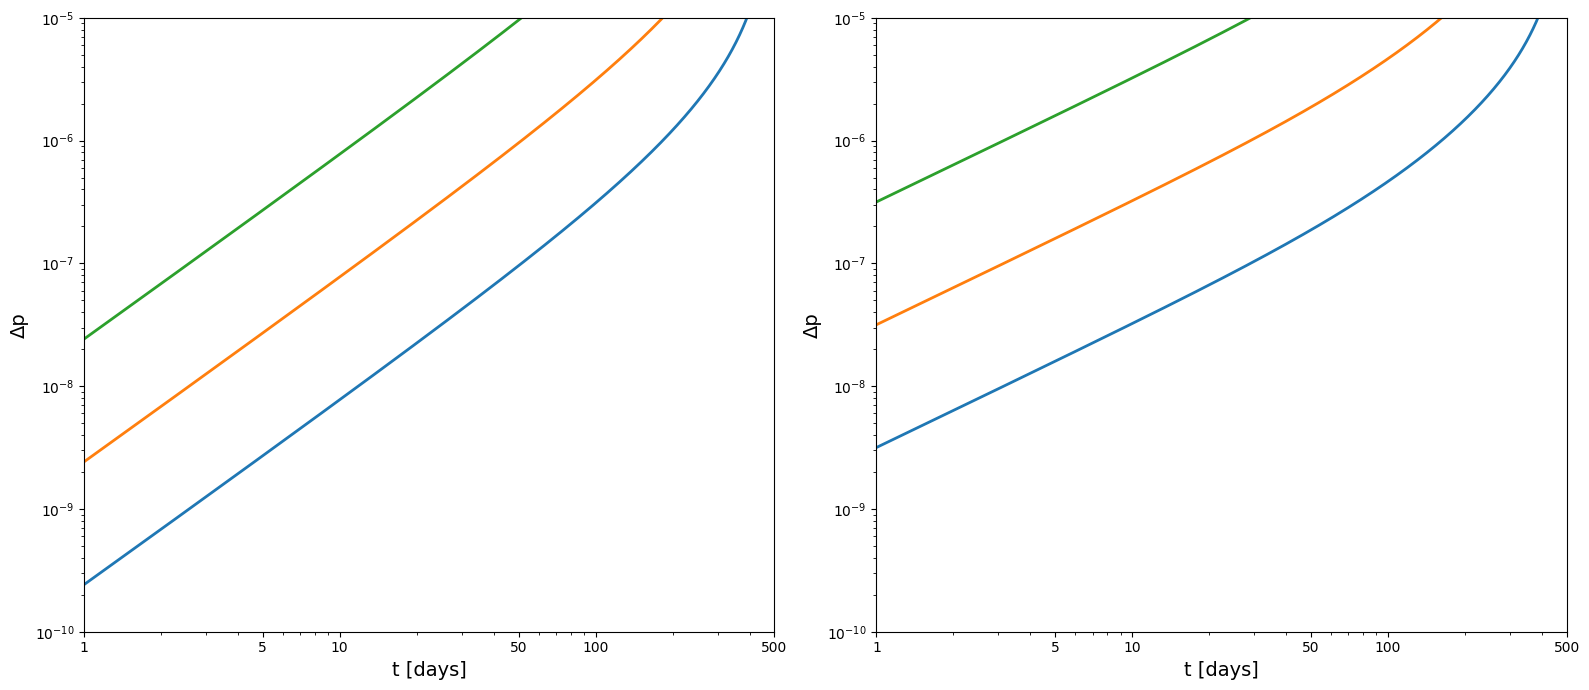

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
M_sol=1e6
m_sol=10
p0=10
D_L=1
T_obs_yr=1.5
e0_values=[0.001,0.1]
r0_values=[0.001,0.01,0.1]
colors=['#1f77b4','#ff7f0e','#2ca02c']
fig,axes=plt.subplots(1,2,figsize=(16,7))
for i,e0 in enumerate(e0_values):
    ax=axes[i]
    GR_generator=LQGWaveformGenerator(M_sol,m_sol,r0=0,p0=p0,e0=e0,D_L=D_L,T_obs_yr=T_obs_yr)
    sol_gr=GR_generator.evolve_trajectory()
    gr_sol=sol_gr.sol
    for j,r0 in enumerate(r0_values):
        LQG_generator=LQGWaveformGenerator(M_sol,m_sol,r0=r0,p0=p0,e0=e0,D_L=D_L,T_obs_yr=T_obs_yr)
        sol_lqg=LQG_generator.evolve_trajectory()
        lqg_sol=sol_lqg.sol

        t_end=min(sol_lqg.t[-1],sol_gr.t[-1])
        times=np.logspace(np.log10(1),np.log10(t_end),5000)

        p_lqg,e_lqg,phi_r_lqg,phi_phi_lqg=lqg_sol(times)
        p_gr,e_gr,phi_r_gr,phi_phi_gr=gr_sol(times)
        delta_P=p_gr-p_lqg
        delta_e=e_gr-e_lqg
        times_in_days=times*LQG_generator.M_sec/(24*3600)
        ax.plot(times_in_days,-delta_e,color=colors[j],linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,500)
    ax.set_ylim(1e-10,1e-5)
    x_ticks=[1,5,10,50,100,500]
    ax.set_xticks(x_ticks)
    ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.set_xlabel('t [days]', fontsize=14)
    ax.set_ylabel('Δp', fontsize=14)

plt.tight_layout()
plt.show()